<img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master/bgsedsc_0.jpg">
$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\bu}{\boldsymbol{u}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

## Customer Churn Analysis and Classification

With the rapid development of telecommunication industry, the service providers are inclined more towards expansion of the subscriber base. To meet the need of surviving in the competitive environment, the retention of existing customers has become a huge challenge. It is stated that the cost of acquiring a new customer is far more than that for retaining the existing one. Therefore, it is imperative for the telecom industries to use advanced analytics to understand consumer behavior and in-turn predict the association of the customers as whether or not they will leave the company.

You are given a dataset: each row represents a customer and each column contains attributes related to customer as described:

+ Churn (target): 1 if customer cancelled service, 0 if not
+ AccountWeeks: number of weeks customer has had active account
+ ContractRenewal: 1 if customer recently renewed contract, 0 if not
+ DataPlan: 1 if customer has data plan, 0 if not
+ DataUsage: gigabytes of monthly data usage
+ CustServCalls: number of calls into customer service
+ DayMins: average daytime minutes per month
+ DayCalls: average number of daytime calls
+ MonthlyCharge: average monthly bill
+ OverageFee: largest overage fee in last 12 months
+ RoamMins: average number of roaming minutes


You are asked to **develop an algorithm** to be able to assess which are the customers that have the highest probability to churn. Besides that you will be asked to answer the 3 following questions:

1. **What variables are contributing to customer churn?** 
2. **Who are the customers more likely to churn?**
3. **What actions can be taken to stop them from leaving?**


You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Create extra variables if needed/possible
3. *Build* your model and test it on the same input data
4. Assess expected accuracy using *cross-validation*
5. Tune the hyperparameters of your model
6. Repeat steps 4 and 5 until you find the best model possible
7. Answer the questions asked

## Main criteria for grading
+ Algorithm implemented
+ AUC score given
+ At least Random Forest and Xgboost are used
+ Data preparation and exploration
+ Hyperparameter optimization 
+ Cross-validation used
+ Code is combined with neat and understandable commentary, with some titles and comments 

## Summary of activies

We run a X models to 

The dataset delivered didn't had NAs, so no assumptions regarding the data processing were made. We created some features that are going to be explained later on, but we didn't opt for create a lot of features like was made in the previous assignment, since for tree-based models this is not the best option. To prove this point we tested the performance of the models with 

After that, we realize the hyperparameter optimization 

Finally, we answered the questions proposed. We'll detail later and show how we got into this conclusion, but the (XXXX - name of the feature) and (XXXX - feature) are the 

We used the CatBoost encoder that help the balance between classes, because otherwise our model wouldn't be trained well to predict the churn, since approximately only 15% of the data is a churn costumer.

In [1]:
import pandas as pd
import shap as shap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import plotly.express as px
from sklearn import metrics
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *
from pymatch.Matcher import Matcher
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv('churn_data.csv', sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


### Exploration of Churn dataset

visualization of Churn dataset- histogram by variable:


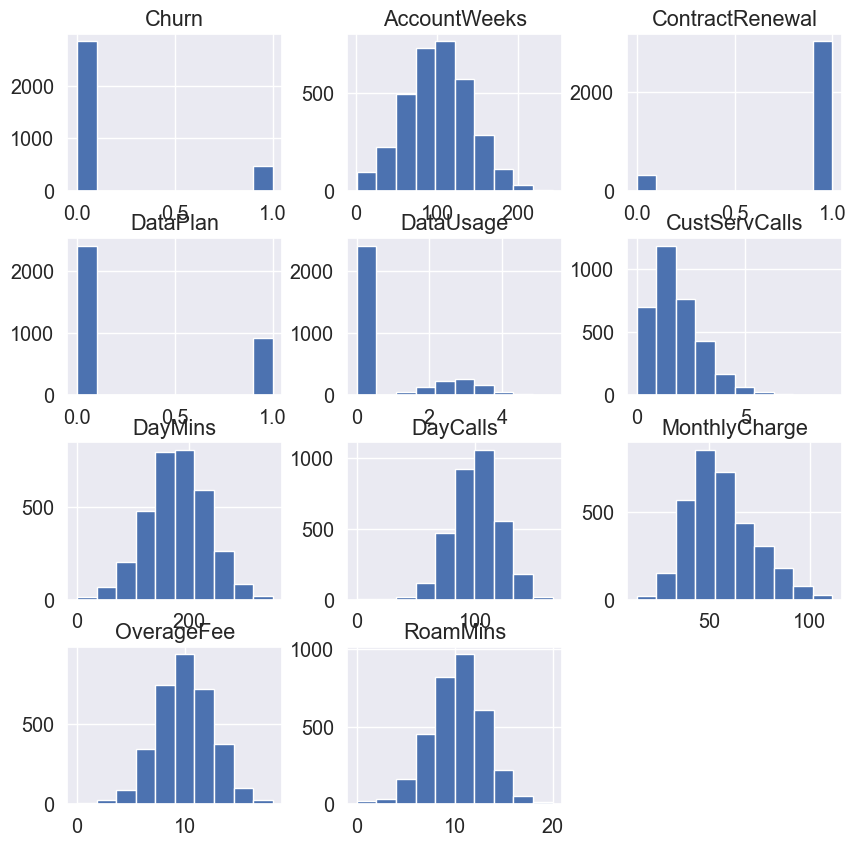

In [3]:
print('visualization of Churn dataset- histogram by variable:')
histogram1 = df.hist(figsize=(10,10))

**Initial observations:**
- Most of the Churns are 0 (makes sense, since most people don't leave their contract in a given month)
- Most of the variables are numerical, some are binary
- Most of the variables resemble a normal distribution
- CustServCalls, MonthlyCharge are skewed to the right
- DataUsage is a bit confusing, it seems like there is a group of users who don't use any data, and then a normal distribution of people who do? I guess that means DataUsage only applies to users where DataPlan == 1

In [4]:
#histogram by color by Churn
for col in df.columns:
    fig1 = px.histogram(df, x=col, color='Churn')
    fig1.show()

**Initial Observations**
- Most users who churn don't have a data plan (400 vs 80)
- The majority of users to who chrun don't have a data plan.
- It looks like most users who Churn have a higher than average MonthlyCharge

### Feature creation

The feature creation is one of the tools we have to improve the accuracy of our model. Differently of the models that automatically select the best features, simply adding features like generation of dummies and interaction terms it's not the best solution, since the model could get confused with useless features.


In the first part, to prove our point we did simulations with a lot of random interaction terms and tested the model with these features. 
Here we will generate polynomials, and add the ones considered most important by a random forest model in predicting churn. We output the AUC score for each set of features.

In the second part we are going to create features that we judge they are valuable features, adding information that we think we will help the classification of the model, based on our expertise.

In [5]:

import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel

#define X and y
X = df.iloc[:,1:]
y = df.iloc[:,0] 


for d in [1,2,3]:
    #generate a dataset of polynomials
    poly = PolynomialFeatures(interaction_only=True, include_bias=False, degree=d)
    X_poly = poly.fit_transform(X)
    X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names_out())

    if d != 1:
        sel = SelectFromModel(RandomForestClassifier())
        
        sel.fit(X_poly, y)

        #get the columns that were most useful in prediction
        selected_feat= X_poly.columns[(sel.get_support())]
        X_poly = X_poly[selected_feat]

    #Evaluate model performance based on selected_features:
    rf = RandomForestClassifier()
 
    scores = cross_val_score(rf, X_poly, y, cv=5, scoring="roc_auc")

    # Evaluate ROC_AUC
    print("From generating dataset of interaction terms with degree %d, ROC AUC = %0.2f with a standard deviation of %0.2f" % (d, scores.mean(), scores.std()))

From generating dataset of interaction terms with degree 1, ROC AUC = 0.90 with a standard deviation of 0.02
From generating dataset of interaction terms with degree 2, ROC AUC = 0.90 with a standard deviation of 0.02
From generating dataset of interaction terms with degree 3, ROC AUC = 0.90 with a standard deviation of 0.02


Our first thought was to generate a lot of polynomial features but as shown above, this doesn't help the AUC performance for the Random Forest model. then after reading [this post on stack exchange](https://stats.stackexchange.com/questions/300254/does-feature-engineering-matter-when-doing-random-forest-or-gradient-boosting), one of the main intutitions was that "additional features and/or poorly engineered features increase the likelihood that you're training your model on noise rather than signal. Hence using domain knowledge or inspection of the data to suggest alternative ways to engineer features will usually improve results." Based on this, we'll read a bit more about churn before generating more features.

Churn, as defined above, is whether or not a customer opts out of a phone plan. Another way to think about it is that churn is a result of customer satisfaction. If a customer is happy- the utility they gain from staying is greater than the cost of staying with a mobile provider, the customer will stay. If the customer is unhappy- their utility is less than the cost of staying, they'll leave.

Understanding what goes into customer satistfaction can help us to create features to predict churn. In that sense, we are going to start now the procedure that create features that make sense.




#### Feature_1 - Complainers costumers
We are assuming that CustServCalls is a variable that reflects the number of calls to the customer service to complain about the product.
We looked into the data by df['CustServCalls'].describe() and see that 75% of the people called 2 times, so we created a varible called 'CustServcalls_groups' that splits the in two groups, the complainers (people who called 2 or more times to the custumer service, assigned 1) and the non-complainers (assigned 0)

In [6]:
# Feature_1 - Complainers costumers

df['CustServCalls_groups'] = np.where(df['CustServCalls'] < 2, 0,
                               np.where(df['CustServCalls'] >= 2, 1, 0))

We based our feature creation in these assumptions:

What makes a happy customer:
- Uses phone plan.
- Phone plan perks meet the needs of the customer (customer doesn't pay for extra stuff, and doesn't need more than he/she has)
- Monetary cost is low relative to the benefit derived from phone plan

What makes an unhappy customer:
- Doesn't use it
- Pays for extra stuff or feels like the plan doesn't meet his/her needs
- Monetary cost is expensive relative to benefit derived from plan

### Prepare df for models

In [7]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

            Hyperparameter Function for best estimator

In [8]:
import numpy as np 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

def estimator(clf, params, X_train, y_train):

    model = RandomizedSearchCV(estimator = clf, param_distributions = params, n_iter = 10, 
                               cv = 4, verbose = False, random_state= 101, n_jobs = -1)
    model.fit(X_train,y_train)


    return model.best_estimator_

## Random Forest

In [9]:
# Import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Instantiate rf
rf = RandomForestClassifier(max_depth=9, random_state=0)
 
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring="roc_auc")

# Evaluate ROC_AUC
print("ROC AUC: %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

ROC AUC: 0.89 with a standard deviation of 0.03


In [10]:

params_rf = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10, 14],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}

model = estimator(RandomForestClassifier(),params_rf, X_train, y_train)

scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc")

# Evaluate ROC_AUC
print("ROC AUC: %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

ROC AUC: 0.88 with a standard deviation of 0.04


## XGBoost

In [11]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(max_depth=9, objective="reg:squarederror", random_state=1)

scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring="roc_auc")

# Evaluate ROC_AUC
print("ROC AUC: %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

#I thought XGBoost was supposed to be really good, surprised it performed worse than random forest. Maybe changing the parameters (hyperparameter optimization) would lead to better AUC score

ROC AUC: 0.85 with a standard deviation of 0.03


In [12]:

params_xg = {'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}


model = estimator(xgb.XGBClassifier(),params_xg, X_train, y_train)

scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc")

# Evaluate ROC_AUC
print("ROC AUC: %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

ROC AUC: 0.87 with a standard deviation of 0.03


## AdaBoost

In [13]:
ada_model = AdaBoostClassifier(n_estimators=100)

# Fit ada to the training set
ada_model.fit(X_train, y_train)
 
# Compute the probabilities of obtaining the positive class
y_pred_ada = ada_model.predict(X_test)

scores = cross_val_score(ada_model, X_train, y_train, cv=5, scoring="roc_auc")

# Evaluate ROC_AUC
print("ROC AUC: %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

ROC AUC: 0.85 with a standard deviation of 0.04


In [14]:
params_ada = {'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}

# Evaluate ROC_AUC
print("ROC AUC: %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
model = estimator(AdaBoostClassifier(),params_ada, X_train, y_train)

scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc")

# Evaluate ROC_AUC
print("ROC AUC: %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

ROC AUC: 0.85 with a standard deviation of 0.04


/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 10 is smaller than n_iter=80. Running 10 iterations. For exhaustive searches, use GridSearchCV.



ROC AUC: 0.84 with a standard deviation of 0.05


## CatBoost

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

cat_model = CatBoostClassifier(verbose = False)
cat_model.fit(X_train, y_train)

expected_y  = y_test
predicted_y = cat_model.predict(X_test)

print(metrics.confusion_matrix(expected_y, predicted_y))

scores = cross_val_score(cat_model, X_train, y_train, cv=5, scoring="roc_auc")

# Evaluate ROC_AUC
print("ROC AUC: %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



[[844  11]
 [ 50  95]]


/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-

ROC AUC: 0.89 with a standard deviation of 0.03


/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [16]:
params_cat = {'num_trees': list(np.linspace(151, 1200, 10, dtype = int))}
               
model = estimator(CatBoostClassifier(),params_cat, X_train, y_train)

scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc")

# Evaluate ROC_AUC
print("ROC AUC: %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 10 is smaller than n_iter=80. Running 10 iterations. For exhaustive searches, use GridSearchCV.

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be rem

Learning rate set to 0.074061
Learning rate set to 0.074061
Learning rate set to 0.043903
0:	learn: 0.6492308	total: 60.1ms	remaining: 9.02s
1:	learn: 0.6139753	total: 61.4ms	remaining: 4.57s
2:	learn: 0.5833319	total: 62.6ms	remaining: 3.09s
3:	learn: 0.5484221	total: 64.2ms	remaining: 2.36s
4:	learn: 0.5203287	total: 66ms	remaining: 1.93s
5:	learn: 0.4934183	total: 68.8ms	remaining: 1.66s
6:	learn: 0.4725548	total: 71.8ms	remaining: 1.48s
Learning rate set to 0.043914
7:	learn: 0.4533721	total: 73.6ms	remaining: 1.31s
8:	learn: 0.4327192	total: 75.4ms	remaining: 1.19s
9:	learn: 0.4145401	total: 76.7ms	remaining: 1.08s
Learning rate set to 0.074061
10:	learn: 0.4009220	total: 79.2ms	remaining: 1.01s
Learning rate set to 0.043914
11:	learn: 0.3851105	total: 81ms	remaining: 938ms
12:	learn: 0.3708437	total: 82.6ms	remaining: 877ms
13:	learn: 0.3607783	total: 83.9ms	remaining: 821ms
Learning rate set to 0.074043
0:	learn: 0.6499498	total: 56.7ms	remaining: 8.5s
14:	learn: 0.3495611	total

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


12:	learn: 0.4219879	total: 81.8ms	remaining: 2.33s
124:	learn: 0.1341655	total: 498ms	remaining: 565ms
114:	learn: 0.1445270	total: 514ms	remaining: 680ms
0:	learn: 0.6607445	total: 6.15ms	remaining: 2.35s
123:	learn: 0.1490444	total: 536ms	remaining: 618ms
126:	learn: 0.1472657	total: 515ms	remaining: 568ms
143:	learn: 0.1673641	total: 515ms	remaining: 25ms
125:	learn: 0.1701147	total: 510ms	remaining: 101ms
115:	learn: 0.1438930	total: 519ms	remaining: 675ms
125:	learn: 0.1337331	total: 506ms	remaining: 566ms
1:	learn: 0.6321953	total: 11.9ms	remaining: 2.26s
126:	learn: 0.1700451	total: 515ms	remaining: 97.3ms
13:	learn: 0.4058974	total: 93.9ms	remaining: 2.48s
144:	learn: 0.1673161	total: 524ms	remaining: 21.7ms
127:	learn: 0.1467917	total: 524ms	remaining: 569ms
14:	learn: 0.3919966	total: 95.1ms	remaining: 2.34s
124:	learn: 0.1488979	total: 547ms	remaining: 621ms
116:	learn: 0.1436854	total: 527ms	remaining: 676ms
2:	learn: 0.6055314	total: 17.1ms	remaining: 2.17s
15:	learn: 0.3

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Learning rate set to 0.031469
30:	learn: 0.2716322	total: 200ms	remaining: 2.28s
144:	learn: 0.1340787	total: 712ms	remaining: 599ms
23:	learn: 0.3054042	total: 135ms	remaining: 2.03s
150:	learn: 0.1394143	total: 731ms	remaining: 562ms
154:	learn: 0.1214587	total: 700ms	remaining: 506ms
162:	learn: 0.1338913	total: 711ms	remaining: 454ms
44:	learn: 0.2297389	total: 284ms	remaining: 2.14s
0:	learn: 0.6618138	total: 5.02ms	remaining: 1.92s
31:	learn: 0.2669450	total: 207ms	remaining: 2.27s
155:	learn: 0.1211945	total: 702ms	remaining: 500ms
145:	learn: 0.1337377	total: 719ms	remaining: 596ms
24:	learn: 0.3002750	total: 141ms	remaining: 2.03s
25:	learn: 0.2964802	total: 142ms	remaining: 1.96s
26:	learn: 0.2902130	total: 143ms	remaining: 1.9s
151:	learn: 0.1388928	total: 739ms	remaining: 559ms
163:	learn: 0.1333919	total: 719ms	remaining: 452ms
27:	learn: 0.2848604	total: 145ms	remaining: 1.84s
1:	learn: 0.6331421	total: 13.3ms	remaining: 2.54s
45:	learn: 0.2277022	total: 294ms	remaining: 

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.p

91:	learn: 0.1627387	total: 586ms	remaining: 1.86s
373:	learn: 0.1026587	total: 792ms	remaining: 21.2ms
255:	learn: 0.1058085	total: 1.31s	remaining: 56.5ms
65:	learn: 0.2190781	total: 111ms	remaining: 727ms
66:	learn: 0.2182722	total: 111ms	remaining: 719ms
127:	learn: 0.1551600	total: 722ms	remaining: 1.44s
239:	learn: 0.1055932	total: 1.3s	remaining: 147ms
67:	learn: 0.2168939	total: 113ms	remaining: 715ms
261:	learn: 0.1053039	total: 1.3s	remaining: 24.8ms
374:	learn: 0.1023641	total: 796ms	remaining: 19.1ms
144:	learn: 0.1551965	total: 867ms	remaining: 1.43s
68:	learn: 0.2157059	total: 114ms	remaining: 713ms
375:	learn: 0.1020575	total: 797ms	remaining: 17ms
376:	learn: 0.1018197	total: 799ms	remaining: 14.8ms
128:	learn: 0.1550188	total: 727ms	remaining: 1.44s
256:	learn: 0.1056133	total: 1.32s	remaining: 51.4ms
92:	learn: 0.1619888	total: 594ms	remaining: 1.86s
377:	learn: 0.1016215	total: 800ms	remaining: 12.7ms
69:	learn: 0.2142385	total: 118ms	remaining: 726ms
145:	learn: 0.1

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


95:	learn: 0.1896197	total: 157ms	remaining: 662ms
173:	learn: 0.1597230	total: 307ms	remaining: 575ms
96:	learn: 0.1888744	total: 159ms	remaining: 662ms
174:	learn: 0.1594883	total: 309ms	remaining: 574ms
20:	learn: 0.3667335	total: 135ms	remaining: 3.07s
175:	learn: 0.1591688	total: 311ms	remaining: 572ms
124:	learn: 0.1473244	total: 786ms	remaining: 1.63s
97:	learn: 0.1880645	total: 162ms	remaining: 666ms
176:	learn: 0.1589586	total: 312ms	remaining: 569ms
157:	learn: 0.1457636	total: 918ms	remaining: 1.31s
32:	learn: 0.2880070	total: 136ms	remaining: 1.93s
98:	learn: 0.1874203	total: 164ms	remaining: 664ms
175:	learn: 0.1463379	total: 1.06s	remaining: 1.26s
177:	learn: 0.1587221	total: 313ms	remaining: 567ms
99:	learn: 0.1866686	total: 165ms	remaining: 661ms
178:	learn: 0.1584100	total: 315ms	remaining: 565ms
100:	learn: 0.1860607	total: 167ms	remaining: 658ms
21:	learn: 0.3599986	total: 140ms	remaining: 3.04s
33:	learn: 0.2836624	total: 140ms	remaining: 1.93s
125:	learn: 0.1471578

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


320:	learn: 0.1222576	total: 919ms	remaining: 512ms
95:	learn: 0.2015072	total: 175ms	remaining: 948ms
30:	learn: 0.3337318	total: 54.7ms	remaining: 1.03s
321:	learn: 0.1218984	total: 920ms	remaining: 509ms
31:	learn: 0.3283186	total: 56.3ms	remaining: 1.03s
96:	learn: 0.2006310	total: 177ms	remaining: 947ms
283:	learn: 0.1161984	total: 1.69s	remaining: 594ms
322:	learn: 0.1215712	total: 922ms	remaining: 505ms
156:	learn: 0.1502052	total: 906ms	remaining: 1.98s
32:	learn: 0.3241211	total: 57.8ms	remaining: 1.02s
97:	learn: 0.1997931	total: 178ms	remaining: 943ms
113:	learn: 0.1918777	total: 770ms	remaining: 3.4s
323:	learn: 0.1213756	total: 923ms	remaining: 502ms
299:	learn: 0.1173136	total: 1.84s	remaining: 516ms
33:	learn: 0.3193842	total: 59.3ms	remaining: 1.02s
236:	learn: 0.1170818	total: 1.57s	remaining: 971ms
324:	learn: 0.1212695	total: 925ms	remaining: 498ms
98:	learn: 0.1987060	total: 181ms	remaining: 946ms
34:	learn: 0.3150519	total: 60.8ms	remaining: 1.01s
325:	learn: 0.121

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


170:	learn: 0.1694885	total: 1.16s	remaining: 3.02s
300:	learn: 0.1400299	total: 570ms	remaining: 599ms
293:	learn: 0.1075546	total: 1.95s	remaining: 598ms
343:	learn: 0.1041912	total: 2.08s	remaining: 241ms
301:	learn: 0.1399270	total: 572ms	remaining: 596ms
345:	learn: 0.1114133	total: 1.3s	remaining: 579ms
239:	learn: 0.1467959	total: 452ms	remaining: 710ms
5:	learn: 0.5801962	total: 18ms	remaining: 1.83s
302:	learn: 0.1397537	total: 573ms	remaining: 594ms
240:	learn: 0.1466134	total: 453ms	remaining: 707ms
6:	learn: 0.5597382	total: 19.5ms	remaining: 1.7s
346:	learn: 0.1113359	total: 1.3s	remaining: 575ms
241:	learn: 0.1464444	total: 455ms	remaining: 705ms
171:	learn: 0.1693463	total: 1.16s	remaining: 3.01s
7:	learn: 0.5438399	total: 21ms	remaining: 1.6s
303:	learn: 0.1395982	total: 577ms	remaining: 594ms
344:	learn: 0.1040800	total: 2.08s	remaining: 235ms
347:	learn: 0.1110802	total: 1.3s	remaining: 570ms
359:	learn: 0.1054046	total: 2.23s	remaining: 149ms
242:	learn: 0.1463148	to

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


394:	learn: 0.1261848	total: 767ms	remaining: 431ms
114:	learn: 0.1782601	total: 213ms	remaining: 929ms
452:	learn: 0.0981440	total: 1.49s	remaining: 155ms
395:	learn: 0.1260129	total: 768ms	remaining: 429ms
115:	learn: 0.1777835	total: 214ms	remaining: 926ms
453:	learn: 0.0980834	total: 1.5s	remaining: 152ms
396:	learn: 0.1256981	total: 770ms	remaining: 427ms
340:	learn: 0.1296829	total: 650ms	remaining: 526ms
454:	learn: 0.0980452	total: 1.5s	remaining: 148ms
116:	learn: 0.1771554	total: 216ms	remaining: 923ms
322:	learn: 0.1015771	total: 2.15s	remaining: 406ms
397:	learn: 0.1256848	total: 771ms	remaining: 424ms
202:	learn: 0.1615911	total: 1.35s	remaining: 2.77s
117:	learn: 0.1766227	total: 218ms	remaining: 920ms
398:	learn: 0.1254959	total: 773ms	remaining: 422ms
341:	learn: 0.1295244	total: 652ms	remaining: 524ms
455:	learn: 0.0979710	total: 1.5s	remaining: 145ms
118:	learn: 0.1760494	total: 219ms	remaining: 916ms
399:	learn: 0.1254444	total: 774ms	remaining: 420ms
342:	learn: 0.1

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


230:	learn: 0.1546250	total: 456ms	remaining: 992ms
65:	learn: 0.2430891	total: 139ms	remaining: 1.4s
3:	learn: 0.6312633	total: 9.02ms	remaining: 1.91s
231:	learn: 0.1542777	total: 458ms	remaining: 989ms
66:	learn: 0.2409705	total: 140ms	remaining: 1.4s
312:	learn: 0.1419334	total: 1.93s	remaining: 1.88s
420:	learn: 0.1113727	total: 806ms	remaining: 375ms
4:	learn: 0.6164252	total: 10.7ms	remaining: 1.82s
67:	learn: 0.2394686	total: 142ms	remaining: 1.39s
18:	learn: 0.4740486	total: 107ms	remaining: 4.69s
80:	learn: 0.2334879	total: 504ms	remaining: 4.05s
232:	learn: 0.1540770	total: 460ms	remaining: 988ms
5:	learn: 0.6045652	total: 12.3ms	remaining: 1.74s
68:	learn: 0.2377825	total: 144ms	remaining: 1.38s
6:	learn: 0.5916980	total: 13.8ms	remaining: 1.66s
233:	learn: 0.1537315	total: 462ms	remaining: 985ms
421:	learn: 0.1111355	total: 810ms	remaining: 374ms
69:	learn: 0.2361245	total: 145ms	remaining: 1.38s
108:	learn: 0.2088364	total: 583ms	remaining: 3.34s
7:	learn: 0.5804780	total

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


476:	learn: 0.1180612	total: 1.05s	remaining: 564ms
304:	learn: 0.1347837	total: 734ms	remaining: 1.03s
39:	learn: 0.3417669	total: 118ms	remaining: 2.4s
218:	learn: 0.1645816	total: 1.09s	remaining: 2.56s
477:	learn: 0.1179512	total: 1.05s	remaining: 561ms
40:	learn: 0.3386353	total: 120ms	remaining: 2.37s
219:	learn: 0.1643390	total: 1.09s	remaining: 2.55s
478:	learn: 0.1178200	total: 1.05s	remaining: 559ms
496:	learn: 0.1139213	total: 2.52s	remaining: 610ms
305:	learn: 0.1346285	total: 738ms	remaining: 1.03s
41:	learn: 0.3329701	total: 121ms	remaining: 2.34s
479:	learn: 0.1177233	total: 1.05s	remaining: 556ms
306:	learn: 0.1344664	total: 739ms	remaining: 1.02s
267:	learn: 0.1602201	total: 608ms	remaining: 1.32s
480:	learn: 0.1176544	total: 1.06s	remaining: 554ms
307:	learn: 0.1344289	total: 741ms	remaining: 1.02s
268:	learn: 0.1600721	total: 609ms	remaining: 1.31s
481:	learn: 0.1175402	total: 1.06s	remaining: 551ms
42:	learn: 0.3300118	total: 126ms	remaining: 2.36s
308:	learn: 0.134

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


52:	learn: 0.2949638	total: 156ms	remaining: 2.34s
393:	learn: 0.1361460	total: 1.91s	remaining: 1.64s
254:	learn: 0.1659525	total: 1.49s	remaining: 3.47s
53:	learn: 0.2917927	total: 157ms	remaining: 2.32s
503:	learn: 0.1098504	total: 1.53s	remaining: 696ms
394:	learn: 0.1360448	total: 1.91s	remaining: 1.63s
504:	learn: 0.1097257	total: 1.53s	remaining: 693ms
395:	learn: 0.1359762	total: 1.91s	remaining: 1.63s
670:	learn: 0.0972332	total: 1.85s	remaining: 171ms
467:	learn: 0.1327332	total: 1.42s	remaining: 1.16s
235:	learn: 0.1590673	total: 934ms	remaining: 2.43s
505:	learn: 0.1096444	total: 1.53s	remaining: 689ms
396:	learn: 0.1356992	total: 1.91s	remaining: 1.62s
468:	learn: 0.1326312	total: 1.42s	remaining: 1.16s
377:	learn: 0.1402003	total: 1.95s	remaining: 1.83s
54:	learn: 0.2881920	total: 163ms	remaining: 2.35s
236:	learn: 0.1587289	total: 936ms	remaining: 2.42s
378:	learn: 0.1400154	total: 1.95s	remaining: 1.82s
397:	learn: 0.1355764	total: 1.91s	remaining: 1.61s
255:	learn: 0.1

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


43:	learn: 0.3510281	total: 112ms	remaining: 2.34s
531:	learn: 0.1211444	total: 2.3s	remaining: 868ms
629:	learn: 0.0971571	total: 1.92s	remaining: 314ms
530:	learn: 0.1201449	total: 2.33s	remaining: 888ms
44:	learn: 0.3461897	total: 113ms	remaining: 2.31s
603:	learn: 0.1185957	total: 1.81s	remaining: 739ms
192:	learn: 0.1653250	total: 544ms	remaining: 1.85s
390:	learn: 0.1457099	total: 1.88s	remaining: 2.21s
365:	learn: 0.1391388	total: 1.32s	remaining: 1.75s
532:	learn: 0.1209471	total: 2.3s	remaining: 863ms
45:	learn: 0.3426587	total: 114ms	remaining: 2.29s
630:	learn: 0.0970635	total: 1.93s	remaining: 311ms
533:	learn: 0.1209305	total: 2.3s	remaining: 857ms
391:	learn: 0.1454576	total: 1.88s	remaining: 2.2s
46:	learn: 0.3391767	total: 116ms	remaining: 2.27s
604:	learn: 0.1185102	total: 1.82s	remaining: 736ms
534:	learn: 0.1208257	total: 2.3s	remaining: 852ms
392:	learn: 0.1452800	total: 1.88s	remaining: 2.19s
605:	learn: 0.1184930	total: 1.82s	remaining: 733ms
366:	learn: 0.1390281

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


728:	learn: 0.1062573	total: 2.2s	remaining: 366ms
21:	learn: 0.4653142	total: 55.8ms	remaining: 2.39s
697:	learn: 0.0993742	total: 2.69s	remaining: 135ms
500:	learn: 0.1235626	total: 1.72s	remaining: 1.2s
624:	learn: 0.1086607	total: 2.72s	remaining: 470ms
22:	learn: 0.4593775	total: 57.2ms	remaining: 2.35s
501:	learn: 0.1235051	total: 1.72s	remaining: 1.19s
625:	learn: 0.1085246	total: 2.72s	remaining: 465ms
23:	learn: 0.4514724	total: 58.6ms	remaining: 2.3s
502:	learn: 0.1234559	total: 1.72s	remaining: 1.19s
698:	learn: 0.0991394	total: 2.69s	remaining: 131ms
626:	learn: 0.1083978	total: 2.72s	remaining: 460ms
24:	learn: 0.4448772	total: 60ms	remaining: 2.26s
503:	learn: 0.1234411	total: 1.72s	remaining: 1.18s
305:	learn: 0.1415225	total: 943ms	remaining: 1.68s
627:	learn: 0.1082396	total: 2.72s	remaining: 455ms
504:	learn: 0.1233449	total: 1.72s	remaining: 1.18s
25:	learn: 0.4385378	total: 62.5ms	remaining: 2.26s
182:	learn: 0.1897116	total: 511ms	remaining: 2.19s
503:	learn: 0.130

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


314:	learn: 0.1616416	total: 899ms	remaining: 1.86s
185:	learn: 0.1851203	total: 452ms	remaining: 1.9s
626:	learn: 0.1175198	total: 2.67s	remaining: 949ms
315:	learn: 0.1613261	total: 901ms	remaining: 1.85s
437:	learn: 0.1248411	total: 1.33s	remaining: 1.25s
186:	learn: 0.1847100	total: 454ms	remaining: 1.89s
7:	learn: 0.6066677	total: 13.6ms	remaining: 1.83s
100:	learn: 0.2282259	total: 274ms	remaining: 2.35s
627:	learn: 0.1174321	total: 2.67s	remaining: 944ms
316:	learn: 0.1611745	total: 902ms	remaining: 1.85s
438:	learn: 0.1247716	total: 1.33s	remaining: 1.25s
187:	learn: 0.1842798	total: 455ms	remaining: 1.88s
317:	learn: 0.1610817	total: 904ms	remaining: 1.84s
628:	learn: 0.1173679	total: 2.67s	remaining: 939ms
439:	learn: 0.1245429	total: 1.33s	remaining: 1.24s
589:	learn: 0.1149642	total: 2.1s	remaining: 926ms
101:	learn: 0.2275403	total: 277ms	remaining: 2.35s
8:	learn: 0.5974613	total: 16.9ms	remaining: 2.02s
629:	learn: 0.1172719	total: 2.67s	remaining: 933ms
440:	learn: 0.12

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


378:	learn: 0.1377110	total: 1.04s	remaining: 1.61s
713:	learn: 0.0986979	total: 2.3s	remaining: 438ms
382:	learn: 0.1563853	total: 998ms	remaining: 1.82s
379:	learn: 0.1374257	total: 1.04s	remaining: 1.61s
714:	learn: 0.0986105	total: 2.3s	remaining: 434ms
10:	learn: 0.5714965	total: 54.2ms	remaining: 5.28s
715:	learn: 0.0985061	total: 2.3s	remaining: 431ms
383:	learn: 0.1563557	total: 1s	remaining: 1.82s
716:	learn: 0.0984651	total: 2.3s	remaining: 427ms
502:	learn: 0.1348613	total: 1.44s	remaining: 1.33s
717:	learn: 0.0983957	total: 2.3s	remaining: 424ms
28:	learn: 0.4398494	total: 95.4ms	remaining: 3.47s
380:	learn: 0.1372386	total: 1.05s	remaining: 1.61s
436:	learn: 0.1363732	total: 1.26s	remaining: 1.53s
718:	learn: 0.0983874	total: 2.31s	remaining: 420ms
381:	learn: 0.1370436	total: 1.05s	remaining: 1.6s
621:	learn: 0.1252046	total: 1.89s	remaining: 1.04s
384:	learn: 0.1562276	total: 1.01s	remaining: 1.82s
719:	learn: 0.0982918	total: 2.31s	remaining: 417ms
382:	learn: 0.1369709

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


734:	learn: 0.1082035	total: 2.04s	remaining: 643ms
704:	learn: 0.1245056	total: 1.78s	remaining: 956ms
296:	learn: 0.1590844	total: 840ms	remaining: 2.22s
773:	learn: 0.1098222	total: 2.23s	remaining: 552ms
735:	learn: 0.1080837	total: 2.05s	remaining: 639ms
705:	learn: 0.1244770	total: 1.78s	remaining: 953ms
297:	learn: 0.1589315	total: 841ms	remaining: 2.22s
774:	learn: 0.1096832	total: 2.23s	remaining: 549ms
268:	learn: 0.1706866	total: 874ms	remaining: 2.65s
736:	learn: 0.1080739	total: 2.05s	remaining: 636ms
706:	learn: 0.1243543	total: 1.79s	remaining: 950ms
298:	learn: 0.1588818	total: 843ms	remaining: 2.21s
775:	learn: 0.1096554	total: 2.23s	remaining: 546ms
737:	learn: 0.1080556	total: 2.05s	remaining: 633ms
31:	learn: 0.4157782	total: 77.3ms	remaining: 2.54s
707:	learn: 0.1242059	total: 1.79s	remaining: 947ms
299:	learn: 0.1588419	total: 844ms	remaining: 2.2s
776:	learn: 0.1095271	total: 2.23s	remaining: 543ms
738:	learn: 0.1080426	total: 2.05s	remaining: 630ms
269:	learn: 0

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


372:	learn: 0.1488674	total: 1.04s	remaining: 1.97s
92:	learn: 0.2447241	total: 264ms	remaining: 2.81s
779:	learn: 0.1176003	total: 1.98s	remaining: 769ms
373:	learn: 0.1487477	total: 1.04s	remaining: 1.97s
93:	learn: 0.2436218	total: 266ms	remaining: 2.8s
22:	learn: 0.4933328	total: 46.9ms	remaining: 2.4s
780:	learn: 0.1175022	total: 1.98s	remaining: 766ms
374:	learn: 0.1485989	total: 1.04s	remaining: 1.96s
606:	learn: 0.1149910	total: 2s	remaining: 1.18s
94:	learn: 0.2421929	total: 268ms	remaining: 2.78s
781:	learn: 0.1173777	total: 1.98s	remaining: 763ms
823:	learn: 0.1058884	total: 2.42s	remaining: 417ms
607:	learn: 0.1149147	total: 2s	remaining: 1.18s
782:	learn: 0.1173430	total: 1.98s	remaining: 760ms
330:	learn: 0.1609645	total: 1.07s	remaining: 2.44s
824:	learn: 0.1058568	total: 2.42s	remaining: 414ms
792:	learn: 0.1033568	total: 2.25s	remaining: 490ms
95:	learn: 0.2409828	total: 271ms	remaining: 2.78s
608:	learn: 0.1147216	total: 2s	remaining: 1.18s
23:	learn: 0.4871736	total:

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


944:	learn: 0.1035271	total: 2.56s	remaining: 374ms
12:	learn: 0.5585659	total: 27.1ms	remaining: 2.47s
20:	learn: 0.5039352	total: 34ms	remaining: 1.91s
283:	learn: 0.1561883	total: 817ms	remaining: 2.3s
228:	learn: 0.1881232	total: 649ms	remaining: 2.75s
792:	learn: 0.1001268	total: 2.6s	remaining: 567ms
13:	learn: 0.5496600	total: 28.6ms	remaining: 2.42s
21:	learn: 0.4955620	total: 35.6ms	remaining: 1.91s
284:	learn: 0.1559252	total: 819ms	remaining: 2.29s
14:	learn: 0.5403217	total: 30.1ms	remaining: 2.38s
22:	learn: 0.4900258	total: 37.1ms	remaining: 1.9s
945:	learn: 0.1035070	total: 2.56s	remaining: 371ms
229:	learn: 0.1880384	total: 652ms	remaining: 2.75s
15:	learn: 0.5325338	total: 31.6ms	remaining: 2.34s
793:	learn: 0.1000377	total: 2.6s	remaining: 564ms
230:	learn: 0.1876718	total: 654ms	remaining: 2.74s
285:	learn: 0.1557058	total: 822ms	remaining: 2.29s
494:	learn: 0.1419659	total: 1.67s	remaining: 1.99s
794:	learn: 0.0999779	total: 2.61s	remaining: 561ms
231:	learn: 0.1875

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


94:	learn: 0.2557501	total: 165ms	remaining: 1.92s
681:	learn: 0.1188336	total: 2.22s	remaining: 1.31s
126:	learn: 0.2238627	total: 619ms	remaining: 5.23s
95:	learn: 0.2544651	total: 167ms	remaining: 1.92s
341:	learn: 0.1665058	total: 1.24s	remaining: 3.1s
96:	learn: 0.2533400	total: 168ms	remaining: 1.91s
909:	learn: 0.0915889	total: 3.19s	remaining: 196ms
604:	learn: 0.1310330	total: 2.26s	remaining: 1.79s
130:	learn: 0.2306413	total: 629ms	remaining: 5.13s
97:	learn: 0.2516423	total: 169ms	remaining: 1.9s
682:	learn: 0.1187454	total: 2.23s	remaining: 1.3s
98:	learn: 0.2504637	total: 170ms	remaining: 1.89s
382:	learn: 0.1416514	total: 1.41s	remaining: 2.58s
127:	learn: 0.2231785	total: 624ms	remaining: 5.22s
99:	learn: 0.2494404	total: 172ms	remaining: 1.89s
100:	learn: 0.2480170	total: 173ms	remaining: 1.88s
605:	learn: 0.1309952	total: 2.27s	remaining: 1.78s
910:	learn: 0.0915170	total: 3.2s	remaining: 193ms
101:	learn: 0.2471093	total: 174ms	remaining: 1.88s
131:	learn: 0.2298376	

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



55:	learn: 0.2712726	total: 87.2ms	remaining: 1.24s
56:	learn: 0.2677904	total: 90.5ms	remaining: 1.26s
57:	learn: 0.2655486	total: 91.9ms	remaining: 1.25s
58:	learn: 0.2632665	total: 93.2ms	remaining: 1.25s
59:	learn: 0.2601724	total: 94.3ms	remaining: 1.24s
60:	learn: 0.2581457	total: 95.5ms	remaining: 1.24s
61:	learn: 0.2557667	total: 99.3ms	remaining: 1.26s
62:	learn: 0.2542010	total: 102ms	remaining: 1.27s
63:	learn: 0.2519699	total: 104ms	remaining: 1.27s
64:	learn: 0.2501643	total: 106ms	remaining: 1.28s
65:	learn: 0.2491415	total: 108ms	remaining: 1.29s
66:	learn: 0.2469596	total: 110ms	remaining: 1.29s
67:	learn: 0.2455190	total: 113ms	remaining: 1.3s
68:	learn: 0.2436908	total: 115ms	remaining: 1.3s
69:	learn: 0.2419981	total: 117ms	remaining: 1.3s
70:	learn: 0.2405371	total: 118ms	remaining: 1.3s
71:	learn: 0.2387246	total: 120ms	remaining: 1.3s
72:	learn: 0.2373171	total: 122ms	remaining: 1.3s
73:	learn: 0.2363008	total: 124ms	remaining: 1.3s
74:	learn: 0.2352458	total: 126

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



11:	learn: 0.5353507	total: 9.91ms	remaining: 692ms
12:	learn: 0.5248279	total: 11.1ms	remaining: 717ms
13:	learn: 0.5139423	total: 12.3ms	remaining: 734ms
14:	learn: 0.5037587	total: 13.6ms	remaining: 758ms
15:	learn: 0.4959032	total: 14.8ms	remaining: 774ms
16:	learn: 0.4856087	total: 16.5ms	remaining: 807ms
17:	learn: 0.4742732	total: 17.5ms	remaining: 809ms
18:	learn: 0.4639604	total: 18.5ms	remaining: 811ms
19:	learn: 0.4546674	total: 19.5ms	remaining: 810ms
20:	learn: 0.4455625	total: 20.4ms	remaining: 806ms
21:	learn: 0.4393372	total: 21.7ms	remaining: 815ms
22:	learn: 0.4323412	total: 22.6ms	remaining: 811ms
23:	learn: 0.4248347	total: 24ms	remaining: 827ms
24:	learn: 0.4172723	total: 25.1ms	remaining: 828ms
25:	learn: 0.4111621	total: 26.1ms	remaining: 829ms
26:	learn: 0.4053534	total: 27.2ms	remaining: 828ms
27:	learn: 0.3986385	total: 28.1ms	remaining: 824ms
28:	learn: 0.3922657	total: 29.2ms	remaining: 826ms
29:	learn: 0.3863240	total: 30.3ms	remaining: 828ms
30:	learn: 0.3

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



102:	learn: 0.2191780	total: 100ms	remaining: 727ms
103:	learn: 0.2182503	total: 101ms	remaining: 726ms
104:	learn: 0.2175598	total: 102ms	remaining: 726ms
105:	learn: 0.2163876	total: 103ms	remaining: 724ms
106:	learn: 0.2150840	total: 104ms	remaining: 724ms
107:	learn: 0.2137640	total: 105ms	remaining: 722ms
108:	learn: 0.2128868	total: 106ms	remaining: 720ms
109:	learn: 0.2122050	total: 107ms	remaining: 720ms
110:	learn: 0.2114368	total: 108ms	remaining: 719ms
111:	learn: 0.2105149	total: 109ms	remaining: 719ms
112:	learn: 0.2094585	total: 110ms	remaining: 720ms
113:	learn: 0.2087334	total: 111ms	remaining: 719ms
114:	learn: 0.2077987	total: 113ms	remaining: 719ms
115:	learn: 0.2072131	total: 114ms	remaining: 719ms
116:	learn: 0.2063443	total: 115ms	remaining: 720ms
117:	learn: 0.2057818	total: 116ms	remaining: 719ms
118:	learn: 0.2051398	total: 117ms	remaining: 719ms
119:	learn: 0.2043938	total: 118ms	remaining: 718ms
120:	learn: 0.2035928	total: 120ms	remaining: 720ms
121:	learn: 

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



5:	learn: 0.6050473	total: 5.62ms	remaining: 790ms
6:	learn: 0.5912687	total: 6.55ms	remaining: 789ms
7:	learn: 0.5780884	total: 7.37ms	remaining: 775ms
8:	learn: 0.5675541	total: 7.99ms	remaining: 747ms
9:	learn: 0.5544243	total: 8.93ms	remaining: 750ms
10:	learn: 0.5449231	total: 9.67ms	remaining: 737ms
11:	learn: 0.5325462	total: 10.6ms	remaining: 737ms
12:	learn: 0.5196519	total: 11.6ms	remaining: 746ms
13:	learn: 0.5111092	total: 12.7ms	remaining: 761ms
14:	learn: 0.5026970	total: 13.8ms	remaining: 769ms
15:	learn: 0.4939166	total: 14.8ms	remaining: 774ms
16:	learn: 0.4834022	total: 16ms	remaining: 786ms
17:	learn: 0.4739697	total: 16.9ms	remaining: 783ms
18:	learn: 0.4650206	total: 18ms	remaining: 786ms
19:	learn: 0.4571983	total: 19ms	remaining: 790ms
20:	learn: 0.4502964	total: 19.9ms	remaining: 787ms
21:	learn: 0.4429683	total: 21.2ms	remaining: 799ms
22:	learn: 0.4354025	total: 22.1ms	remaining: 794ms
23:	learn: 0.4261970	total: 23ms	remaining: 793ms
24:	learn: 0.4199277	tota

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



99:	learn: 0.2080655	total: 96.4ms	remaining: 723ms
100:	learn: 0.2073499	total: 97.5ms	remaining: 723ms
101:	learn: 0.2067487	total: 98.6ms	remaining: 723ms
102:	learn: 0.2054704	total: 99.5ms	remaining: 722ms
103:	learn: 0.2045711	total: 101ms	remaining: 722ms
104:	learn: 0.2037561	total: 101ms	remaining: 720ms
105:	learn: 0.2029035	total: 102ms	remaining: 718ms
106:	learn: 0.2018850	total: 103ms	remaining: 719ms
107:	learn: 0.2006312	total: 104ms	remaining: 718ms
108:	learn: 0.2000227	total: 105ms	remaining: 716ms
109:	learn: 0.1992247	total: 107ms	remaining: 716ms
110:	learn: 0.1983786	total: 108ms	remaining: 716ms
111:	learn: 0.1978511	total: 109ms	remaining: 715ms
112:	learn: 0.1968795	total: 110ms	remaining: 715ms
113:	learn: 0.1960655	total: 110ms	remaining: 713ms
114:	learn: 0.1950500	total: 111ms	remaining: 713ms
115:	learn: 0.1944633	total: 112ms	remaining: 711ms
116:	learn: 0.1935134	total: 113ms	remaining: 710ms
117:	learn: 0.1927273	total: 114ms	remaining: 710ms
118:	lear

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



5:	learn: 0.6044233	total: 5.42ms	remaining: 763ms
6:	learn: 0.5881164	total: 6.36ms	remaining: 766ms
7:	learn: 0.5749462	total: 7.22ms	remaining: 760ms
8:	learn: 0.5630014	total: 7.98ms	remaining: 746ms
9:	learn: 0.5500931	total: 8.77ms	remaining: 737ms
10:	learn: 0.5416312	total: 9.8ms	remaining: 748ms
11:	learn: 0.5292970	total: 10.8ms	remaining: 752ms
12:	learn: 0.5179323	total: 11.8ms	remaining: 759ms
13:	learn: 0.5094255	total: 13.3ms	remaining: 795ms
14:	learn: 0.4984427	total: 14.3ms	remaining: 795ms
15:	learn: 0.4894930	total: 15.2ms	remaining: 793ms
16:	learn: 0.4804772	total: 16.1ms	remaining: 790ms
17:	learn: 0.4705113	total: 17.5ms	remaining: 807ms
18:	learn: 0.4614138	total: 18.4ms	remaining: 805ms
19:	learn: 0.4533898	total: 19.6ms	remaining: 811ms
20:	learn: 0.4467588	total: 20.5ms	remaining: 810ms
21:	learn: 0.4377398	total: 21.4ms	remaining: 807ms
22:	learn: 0.4287103	total: 22.3ms	remaining: 803ms
23:	learn: 0.4216926	total: 23.3ms	remaining: 803ms
24:	learn: 0.41523

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



### Feature Importance

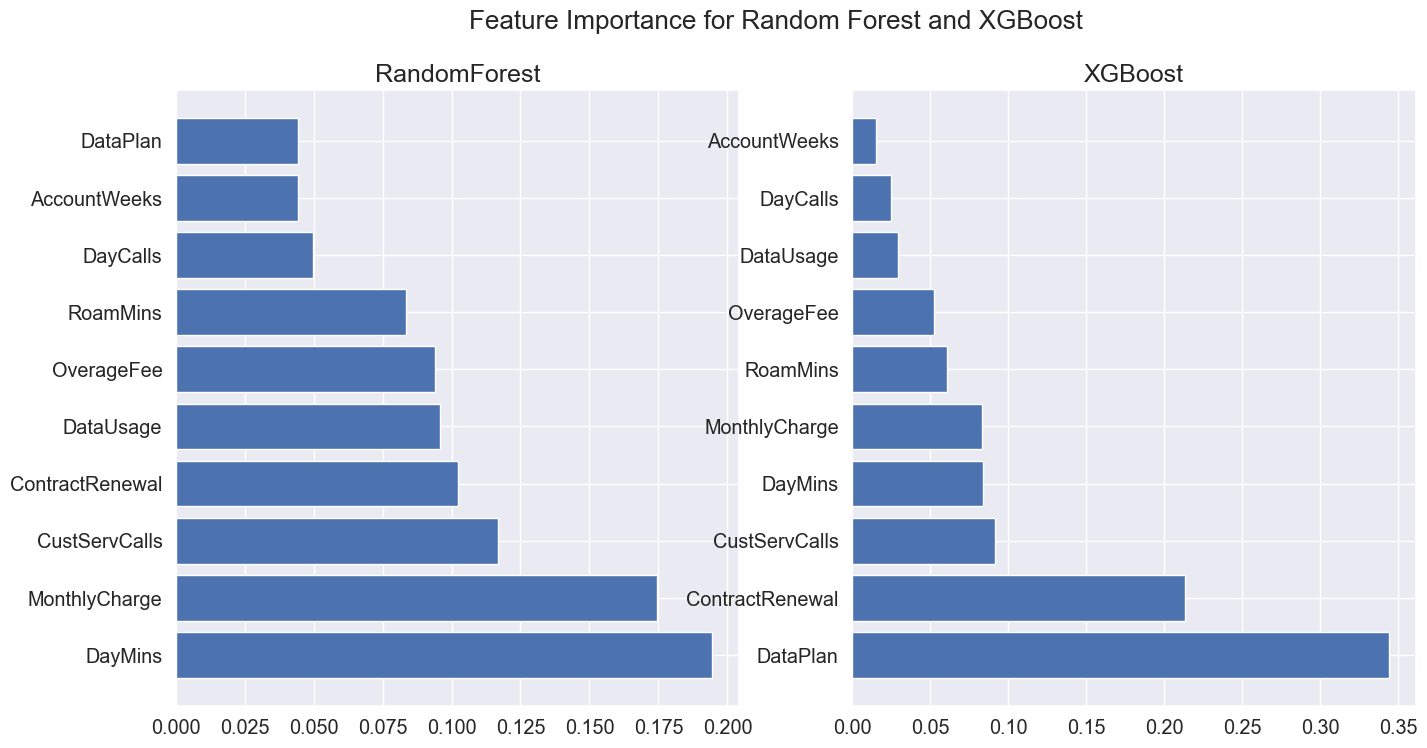

In [17]:
#Not sure how to get feature importance from cross_val_score above, so i am fitting the rf model to the X and y data to generate feature importances.


#DF of Feature importance for random forest
rf_feature_importance = pd.DataFrame(rf.fit(X_train, y_train).feature_importances_, index=X_train.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

#DF of Feature importance for random forest
xgb_feature_importance = pd.DataFrame(xgb_model.fit(X_train, y_train).feature_importances_, index=X_train.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

#plot results of feature importance
fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].barh(rf_feature_importance.index, rf_feature_importance.Importance)
axes[1].barh(xgb_feature_importance.index, xgb_feature_importance.Importance)
axes[0].set_title('RandomForest', fontsize=18)
axes[1].set_title('XGBoost', fontsize=18)
fig.suptitle('Feature Importance for Random Forest and XGBoost')
plt.show()

#I find it interesting that the two models have different variables they consider important. Especially DataPlan! Did I do this wrong or something lol

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



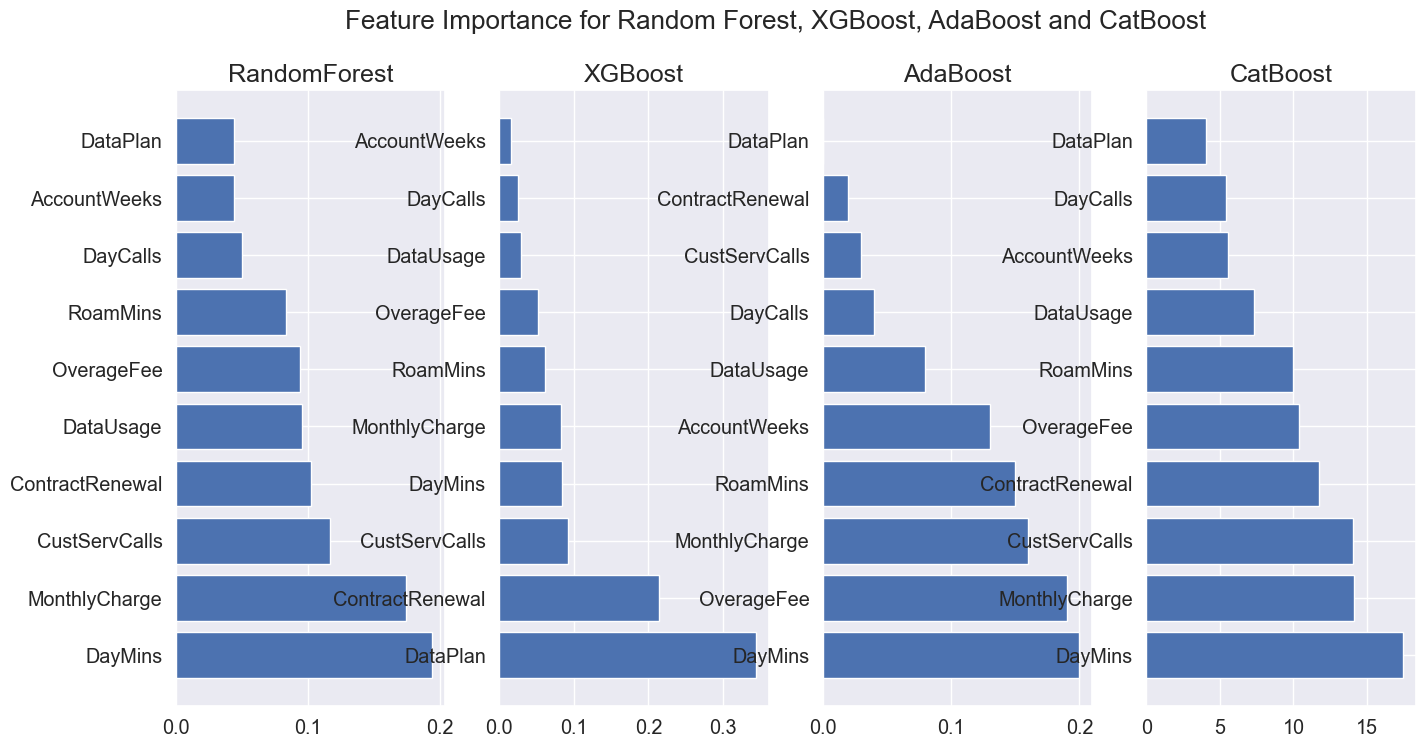

In [18]:
#Not sure how to get feature importance from cross_val_score above, so i am fitting the rf model to the X and y data to generate feature importances.


#DF of Feature importance for random forest
rf_feature_importance = pd.DataFrame(rf.fit(X_train, y_train).feature_importances_, index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

#DF of Feature importance for XGBoost
xgb_feature_importance = pd.DataFrame(xgb_model.fit(X_train, y_train).feature_importances_, index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

#DF of Feature importance for AdaBoost
ada_feature_importance = pd.DataFrame(ada_model.fit(X_train, y_train).feature_importances_, index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

#DF of Feature importance for CatBoost
cat_feature_importance = pd.DataFrame(cat_model.fit(X_train, y_train).feature_importances_, index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

#plot results of feature importance
fig, axes = plt.subplots(1, 4, figsize=(16,8))
axes[0].barh(rf_feature_importance.index, rf_feature_importance.Importance)
axes[1].barh(xgb_feature_importance.index, xgb_feature_importance.Importance)
axes[2].barh(ada_feature_importance.index, ada_feature_importance.Importance)
axes[3].barh(cat_feature_importance.index, cat_feature_importance.Importance)
axes[0].set_title('RandomForest', fontsize=18)
axes[1].set_title('XGBoost', fontsize=18)
axes[2].set_title('AdaBoost', fontsize=18)
axes[3].set_title('CatBoost', fontsize=18)
fig.suptitle('Feature Importance for Random Forest, XGBoost, AdaBoost and CatBoost')
plt.show()

#I find it interesting that the two models have different variables they consider important. Especially DataPlan! Did I do this wrong or something lol

Some things we can explore:
- hyperparemeter optimization
- confusion matrices (maybe)
- feature importance- maybe create additional variables based on initial assessment of feature importance
- understand who are the customers most likely to churn
- what actions can be taken to stop them from leaving?


## Confusion Matrix

### Random Forest

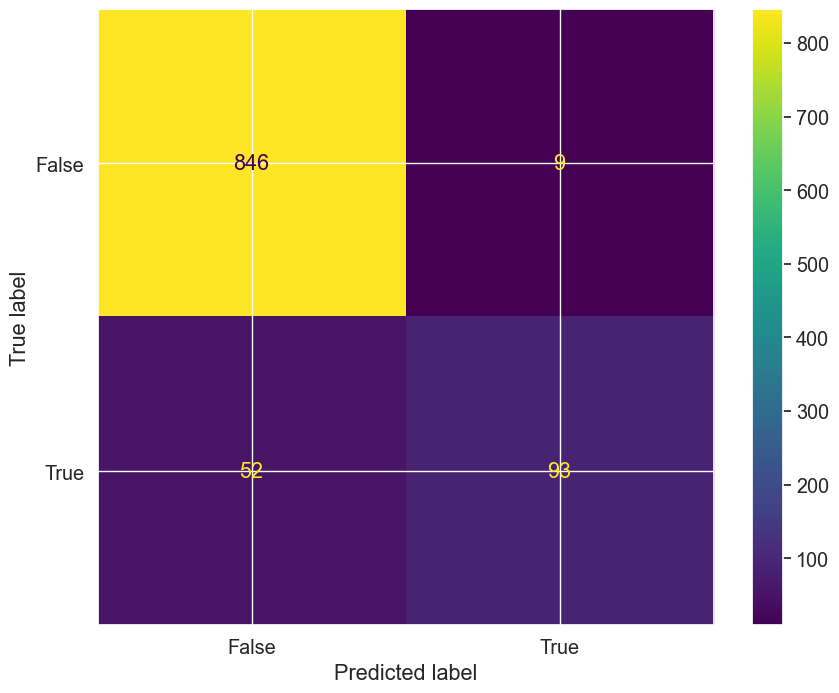

In [19]:
# generating confusion matrix - comparing actual, predicted
observed = y_test
predicted = rf.predict(X_test)
confusion_matrix = metrics.confusion_matrix(observed, predicted)


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

### XGBoost

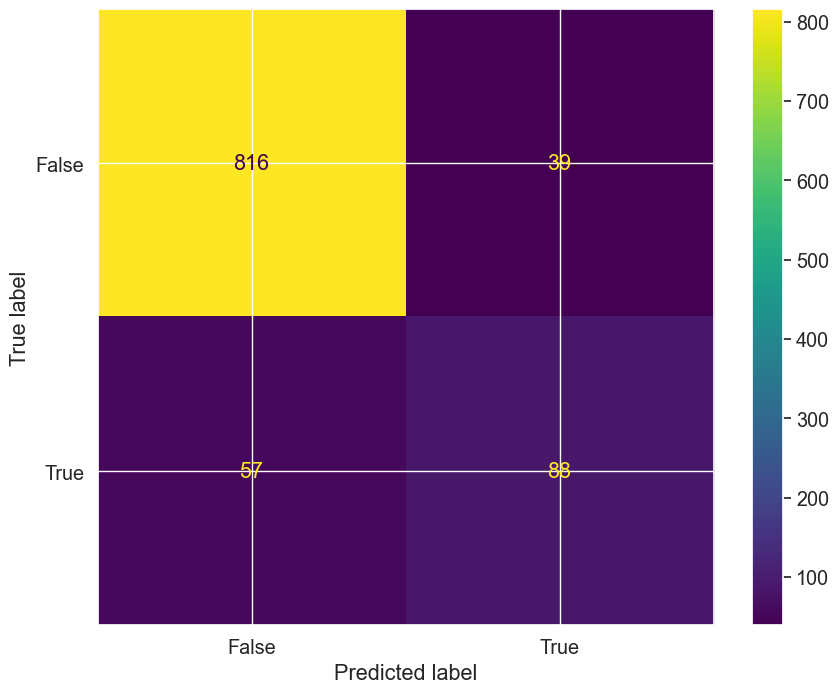

In [20]:
# generating confusion matrix - comparing actual, predicted
observed = y_test
predicted = xgb_model.predict(X_test)
confusion_matrix = metrics.confusion_matrix(observed, predicted)


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

### AdaBoost

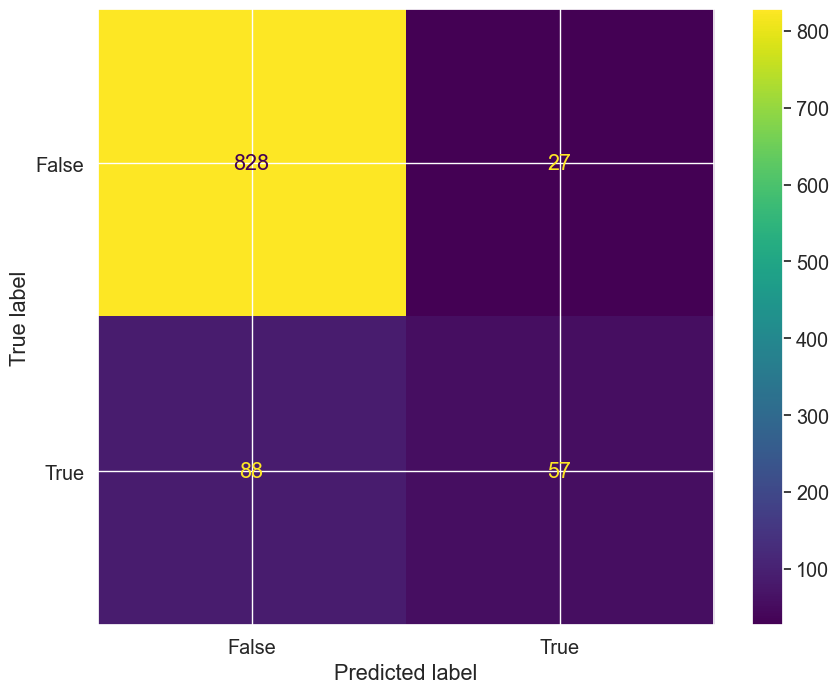

In [21]:
# generating confusion matrix - comparing actual, predicted
observed = y_test
predicted = ada_model.predict(X_test)
confusion_matrix = metrics.confusion_matrix(observed, predicted)


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

### CatBoost

/Users/luisquinonespr/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



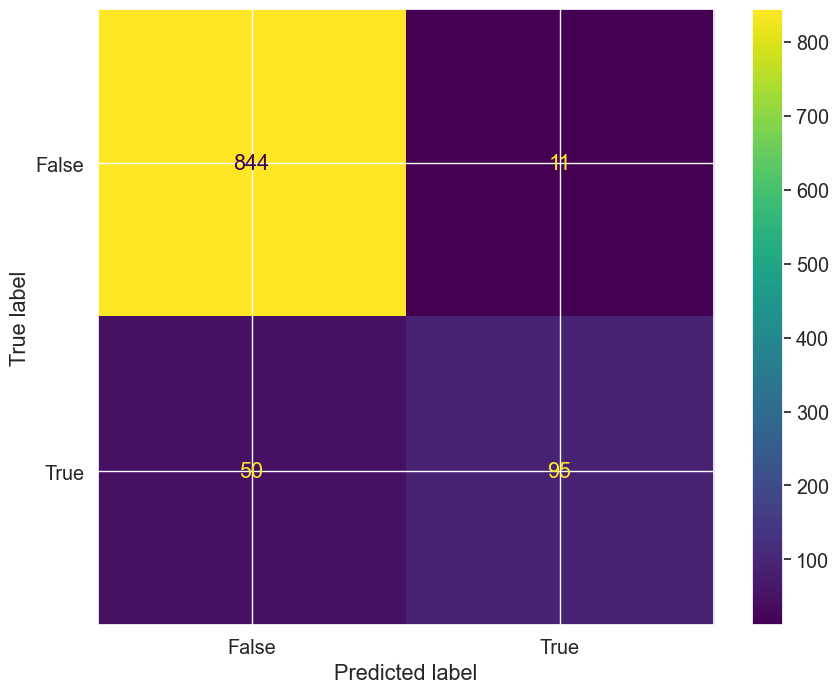

In [22]:
# generating confusion matrix - comparing actual, predicted
observed = y_test
predicted = cat_model.predict(X_test)
confusion_matrix = metrics.confusion_matrix(observed, predicted)


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

### **Who are the customers more likely to churn?**

To answer this question, we can use sklearn's predict_proba function to output the probability that a given observation will churn or not.

In [23]:
rf = RandomForestClassifier(max_depth=9, random_state=0)
 
rf.fit(X_train, y_train)
log_predictions = pd.DataFrame(rf.predict_log_proba(X_test),columns=['LogPr0','LogPr1'])
predictions = pd.DataFrame(rf.predict_proba(X_test),columns=['Pr(Churn)==0','Probability(Churn)==1'])


In [24]:
fig1 = px.box(predictions,  x=y_test, y="Probability(Churn)==1", color=y_test, title="Probability that a customer churns", labels={
                     "x": "Churn"})
fig1.show()

When we plot the predictions, we get a lot of predicted probabilities really close to zero from the Churn==0 class. We can also plot the log probabilities to better visualize the distribution. 

We can also see here that in general, the model is more likely to predict a false negative (predict a low probability when Churn is 1) than a false positive (predict a high probability when Churn is 0).

In [25]:
fig1 = px.box(log_predictions,  x=y_test, y="LogPr1", color=y_test, title="Log Probability that a customer churns", labels={
                     "x": "Churn"})
fig1.show()

### **What actions can be taken to stop them from leaving?**

To answer this question, we take a subset of the sample. We can think of Customers as falling into one of three categories:
- Happy customer (unlikely to Churn)
- Indifferent customer (may or may not Churn)
- Unhappy customer (likely to Churn)

We will examine the indifferent and unhappy customers, since those are the ones that have a mid-high probability of leaving. We will define this subset as custmers with a log probability greater than the upper limit of the third quartile range.

To understand the differences between those that actually leave and don't leave, we will use a Ridge model to predict Churn for this subset, as Ridge is more easily interpretable than a RandomForest or XGboost model.

Our method to answer this question is as follows:
- Take the subset of customers that have a mid-high probabiility of leaving
- Create polynomials to look at interactions
- Scale the data
- Fit to ridge model
- Transform the beta coefficients to original scale
- Use the coefficients to understand what actions can be taken

In [26]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import plotly.express as px

#get the customers who are 'mid-high' probability of leaving
mid_high = (log_predictions.LogPr1 > -2.7776) #& (log_predictions.LogPr1 < -1.218)

X_mid = X_test.reset_index(drop=True)[mid_high]
y_mid = y_test.reset_index(drop=True)[mid_high]

In [27]:
#generate interaction terms
poly = PolynomialFeatures(interaction_only=True, include_bias=False, degree=2)
X_poly = poly.fit_transform(X_mid)
X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names_out())

#scale the dataa
scalerX = StandardScaler().fit(X_poly)
X_scaled = scalerX.transform(X_poly)
X_scaled = pd.DataFrame(X_scaled, columns=scalerX.get_feature_names_out())

#fit Ridge model
ridge = Ridge()
ridge.fit(X_scaled, y_mid)

Ridge()

In [28]:
#get the coefficients of the fitted ridge model
coefs = pd.DataFrame(data=ridge.coef_, columns=['coef'])
coefs.set_index(X_poly.columns, inplace=True)
coefs['importance'] = abs(coefs.coef)
coefs.sort_values(by='importance', ascending=False, inplace=True)

#get the first 10
coefs = coefs.head(10)

In [29]:
px.bar(coefs, x=coefs.index, y='coef', title='Largest coefficients for Ridge model')

Based on this model, when someone has a higher probability of leaving:
- When the number of CustServCalls increases, the likelihood of Churn does as well. This is likely more correlation than causation (people who spend more time talking to customer service are probably unhappy). Maybe they could:
    - Ask people who are on the phone to rate the quality of service. Understand the difference between Churn outcomes for those with positive customer service experiences and negative experiences.
    - If positive customer service calls lead to lower churn rates, focus on improving the quality of their customer service
